In [1]:
# -*- coding: utf-8 -*-
import os
import pandas as pd
import numpy as np
from PIL import Image
import gc, math
import pickle
from collections import Counter

from keras.models import Sequential
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.models import model_from_json
from keras.models import Model
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, merge, Reshape, Activation
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import backend as K
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import log_loss, accuracy_score, confusion_matrix

from cnnmodels import vgg_std16_model, preprocess_input, create_rect5, load_img, train_generator, test_generator
from cnnmodels import identity_block, testcv_generator, conv_block, resnet50_model

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
# Params
img_rows, img_cols = 224, 224 # Resolution of inputs
channel = 3
num_class = 2
ROWS, COLS = 224, 224
BATCHSIZE = 64
SEAL_CLASSES = ['seals_0', 'seals_1', 'seals_2_4', 'seals_5_10', 'seals_11+']
nb_perClass = int(BATCHSIZE / len(SEAL_CLASSES))
TRAIN_DIR = '../darknet/seals/JPEGImagesBlk'
TEST_DIR = '../darknet/seals/JPEGImagesTest'
num_class = len(SEAL_CLASSES)

In [3]:
# Data generator
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True)

# Fine-tune Example
rfcnCVtmp = pd.read_pickle('../coords/rfcnmultiCV.pkl')
rfcnCVtmp.head(3)

,img,proba,x0,y0,x1,y1,seal
0,228_54,0.894,364.95,295.10,464.95,395.10,0
1,228_54,0.893,228.20,376.30,328.20,476.30,0
2,228_54,0.720,407.75,409.95,507.75,509.95,0


In [4]:
# Read in the previous preds 
dftmp = pd.concat([pd.read_csv('../coords/vggCVPreds2604_fold2.csv'),
                pd.read_csv('../coords/vggCVPreds2604_fold1.csv')])
dftmp.columns = ['img1', 'predSeal']


In [5]:

rfcnCV = pd.concat([rfcnCVtmp.reset_index(drop=True), dftmp.reset_index(drop=True)], axis=1)
rfcnCV = rfcnCV[rfcnCV['predSeal']>0.2]
Counter(rfcnCV.seal)

Counter({0: 6512,
         1: 12900,
         2: 10070,
         3: 6830,
         4: 4906,
         5: 3199,
         6: 2106,
         7: 1364,
         8: 937,
         9: 628,
         10: 417,
         11: 260,
         12: 179,
         13: 148,
         14: 94,
         15: 54,
         16: 40,
         17: 31,
         18: 22,
         19: 14,
         20: 15,
         21: 6,
         22: 2,
         23: 2,
         24: 1,
         25: 3})

In [6]:
rfcnCV['seal_cut'] = pd.cut(rfcnCV['seal'], bins = [-1,0,1,4,10,30])

In [7]:
# Make classes
rfcnCV['seals_0'] = np.where(rfcnCV['seal']==0, 1, 0)
rfcnCV['seals_1'] = np.where(rfcnCV['seal'] == 1, 1, 0)
rfcnCV['seals_2_4'] = np.where(rfcnCV['seal'].between(2,4), 1, 0)
rfcnCV['seals_5_10'] = np.where(rfcnCV['seal'].between(5,10), 1, 0)
rfcnCV['seals_11+'] = np.where(rfcnCV['seal']>10, 1, 0)
rfcnCV.head(5)

,img,proba,x0,y0,x1,y1,seal,img1,predSeal,seal_cut,seals_0,seals_1,seals_2_4,seals_5_10,seals_11+
12,332_22,0.998,444.00,9.25,544.00,109.25,1,332_22,0.987439,"(0, 1]",0,1,0,0,0
13,332_22,0.925,261.45,195.15,361.45,295.15,1,332_22,0.999877,"(0, 1]",0,1,0,0,0
18,448_21,0.989,0.00,422.25,100.00,522.25,0,448_21,0.942756,"(-1, 0]",1,0,0,0,0
23,338_32,0.958,444.00,444.00,544.00,544.00,2,338_32,0.944517,"(1, 4]",0,0,1,0,0
24,338_32,0.917,444.00,4.40,544.00,104.40,2,338_32,0.994015,"(1, 4]",0,0,1,0,0


In [8]:
# Lets make our validation set
folds = [rfcnCV.img.str.split('_').apply(lambda x: x[0]).astype(int) % 2 != 0,
        rfcnCV.img.str.split('_').apply(lambda x: x[0]).astype(int) % 2 == 0]
rfcnCV.shape

(50740, 15)

In [9]:
def train_generator(datagen, df):
    while 1:
        batch_x = np.zeros((BATCHSIZE, ROWS, COLS, 3), dtype=K.floatx())
        batch_y = np.zeros((BATCHSIZE, len(SEAL_CLASSES)), dtype=K.floatx())
        fn = lambda obj: obj.loc[np.random.choice(obj.index, size=nb_perClass, replace=False),:]
        batch_df = df.groupby(['seal_cut'], as_index=True).apply(fn)
        i = 0
        for index,row in batch_df.iterrows():
            row = row.tolist()
            image_file = os.path.join(TRAIN_DIR, row[0])
            seal = row[6]
            bbox = row[2:6]
            cropped = load_img(image_file+'.jpg',bbox,target_size=(ROWS,COLS))
            x = np.asarray(cropped, dtype=K.floatx())
            x = datagen.random_transform(x)
            x = preprocess_input(x)
            batch_x[i] = x
            batch_y[i] = row[10:] # Add in all classes
            i += 1
        yield (batch_x.transpose(0, 3, 1, 2), batch_y)
        #return (batch_x.transpose(0, 3, 1, 2), batch_y)

In [10]:
def testcv_generator(df, datagen = None, batch_size = BATCHSIZE):
    n = df.shape[0]
    batch_index = 0
    while 1:
        current_index = batch_index * batch_size
        if n >= current_index + batch_size:
            current_batch_size = batch_size
            batch_index += 1    
        else:
            current_batch_size = n - current_index
            batch_index = 0        
        batch_df = df[current_index:current_index+current_batch_size]
        batch_x = np.zeros((batch_df.shape[0], ROWS, COLS, 3), dtype=K.floatx())
        i = 0
        for index,row in batch_df.iterrows():
            row = row.tolist()
            image_file = os.path.join(TRAIN_DIR, row[0]+'.jpg')
            bbox = row[2:6]
            cropped = load_img(image_file,bbox,target_size=(ROWS,COLS))
            x = np.asarray(cropped, dtype=K.floatx())
            if datagen is not None: x = datagen.random_transform(x)            
            x = preprocess_input(x)
            batch_x[i] = x
            i += 1
        if batch_index%50 == 0: print(batch_index)
        #return(batch_x.transpose(0, 3, 1, 2))
        yield(batch_x.transpose(0, 3, 1, 2))

In [11]:
for fold in range(2):
    print "Fold: " + str(fold+1)
    train_df = rfcnCV[~folds[fold]]
    test_df = rfcnCV[folds[fold]]
    valid_df = test_df[:1500]
    
    # validation_data (valid_x,valid_y)
    print "Part ... A"
    df_1 = valid_df
    l = valid_df.groupby('seal').size()
    nb_NoF_valid = math.ceil(l.sum()/10)
    valid_x = np.zeros((valid_df.shape[0], ROWS, COLS, 3), dtype=K.floatx())
    valid_y = np.zeros((valid_df.shape[0], len(SEAL_CLASSES)), dtype=K.floatx())
    i = 0
    for index,row in valid_df.iterrows():
        if index % 300 == 0 : print index
        row = row.tolist()
        image_file = os.path.join(TRAIN_DIR, row[0])
        seal = row[6]
        bbox = row[2:6]
        cropped = load_img(image_file+'.jpg',bbox,target_size=(ROWS,COLS))
        x = np.asarray(cropped, dtype=K.floatx())
        x = preprocess_input(x)
        valid_x[i] = x
        valid_y[i] = row[10:]
        i += 1
    valid_x = valid_x.transpose(0, 3, 1, 2)
    valid_x.shape

    # Load our model
    print "Part ... B"
    nb_epoch = 2
    samples_per_epoch = 50000
    model = vgg_std16_model(ROWS, COLS, channel, num_class)

    # Start Fine-tuning
    print "Part ... C"
    model.fit_generator(train_generator(train_datagen, train_df),
              nb_epoch=nb_epoch,
              samples_per_epoch=samples_per_epoch, #50000,
              verbose=1,
              validation_data=(valid_x, valid_y),
              )

    for layer in model.layers[10:]:
        layer.trainable = True
    model.optimizer.lr = 1e-4
    nb_epoch = 3
    print "Part ... D"
    model.fit_generator(train_generator(train_datagen, df=train_df),
              nb_epoch=nb_epoch,
              samples_per_epoch=samples_per_epoch,
              verbose=1,
              validation_data=(valid_x, valid_y),
              )

    # Test preds save
    print "Part ... E"
    test_preds = model.predict_generator(testcv_generator(test_df), val_samples=test_df.shape[0])
    df = pd.concat([test_df.reset_index(drop=True), pd.DataFrame(test_preds,  columns=SEAL_CLASSES)], axis=1)
    df.to_pickle('../coords/vggCVMultiPreds1605_fold' + str(fold+1) + '.pkl')
    df[['img', 'predSeal']].to_csv('../coords/vggCVMultiPreds1605_fold' + str(fold+1) + '.csv', index=False)
    
    # Clean up
    del model, train_df, test_df, valid_df, valid_x, df_1
    gc.collect()
    gc.collect()

Fold: 1
Part ... A
72300
74400
75300
Part ... B
Part ... C
Epoch 1/2
49984/50000 [============================>.] - ETA: 0s - loss: 0.7973 - acc: 0.6597

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


50048/50000 [==============================] - 3002s - loss: 0.7971 - acc: 0.6598 - val_loss: 0.8022 - val_acc: 0.6607
Epoch 2/2
50048/50000 [==============================] - 2966s - loss: 0.4726 - acc: 0.8064 - val_loss: 0.8106 - val_acc: 0.6660
Part ... D
Epoch 1/3
50048/50000 [==============================] - 2967s - loss: 0.3853 - acc: 0.8445 - val_loss: 0.8322 - val_acc: 0.6593
Epoch 2/3
50048/50000 [==============================] - 2965s - loss: 0.3273 - acc: 0.8675 - val_loss: 0.8502 - val_acc: 0.6740
Epoch 3/3
50048/50000 [==============================] - 2969s - loss: 0.2745 - acc: 0.8898 - val_loss: 0.8581 - val_acc: 0.6840
Part ... E
50
100
150
200
250
300
350
400
0
Fold: 2
Part ... A
600
3000
4200
Part ... B
Part ... C
Epoch 1/2
50048/50000 [==============================] - 2958s - loss: 1.0042 - acc: 0.5606 - val_loss: 1.0764 - val_acc: 0.5113
Epoch 2/2
50048/50000 [==============================] - 2962s - loss: 0.6200 - acc: 0.7279 - val_loss: 0.8240 - val_acc: 0.62

In [39]:
df = pd.read_pickle('../coords/vggCVMultiPreds1605_fold1.pkl')
df[[0]+range(15, 20)].to_csv('../coords/vggCVMultiPreds1605_fold1.csv', index=False)
df = pd.read_pickle('../coords/vggCVMultiPreds1605_fold2.pkl')
df[[0]+range(15, 20)].to_csv('../coords/vggCVMultiPreds1605_fold2.csv', index=False)

In [34]:
df = pd.read_pickle('../coords/vggCVMultiPreds1605_fold1.pkl')
df.head(5)

,img,proba,x0,y0,x1,y1,seal,img1,predSeal,seal_cut,seals_0,seals_1,seals_2_4,seals_5_10,seals_11+,seals_0,seals_1,seals_2_4,seals_5_10,seals_11+
0,163_81,0.981,335.25,85.50,435.25,185.50,1,163_81,0.999845,"(0, 1]",0,1,0,0,0,5.572001e-05,0.802429,0.197476,0.000039,4.531839e-08
1,163_81,0.976,214.70,207.00,314.70,307.00,1,163_81,0.999891,"(0, 1]",0,1,0,0,0,2.827033e-05,0.813895,0.186002,0.000074,2.873947e-07
2,163_81,0.949,0.00,444.00,100.00,544.00,0,163_81,0.946420,"(-1, 0]",1,0,0,0,0,8.843631e-01,0.102729,0.012882,0.000026,4.393519e-07
3,195_44,0.976,0.00,366.70,100.00,466.70,5,195_44,0.806825,"(4, 10]",0,0,0,1,0,6.955792e-05,0.000384,0.015496,0.979721,4.329350e-03
4,195_44,0.967,0.00,227.25,100.00,327.25,8,195_44,0.999979,"(4, 10]",0,0,0,1,0,1.282985e-07,0.000006,0.006371,0.993615,7.667681e-06


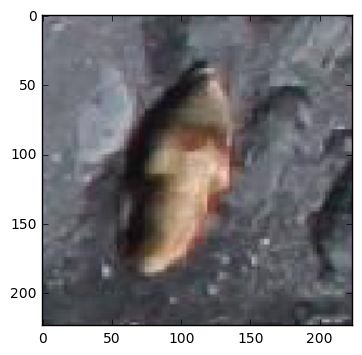

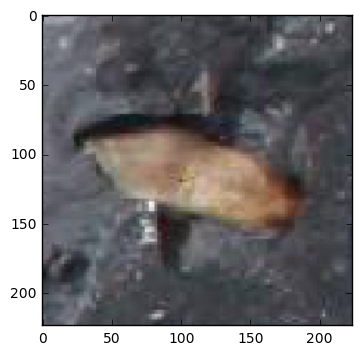

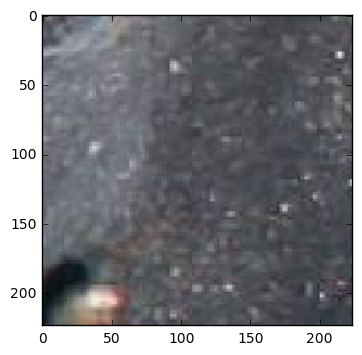

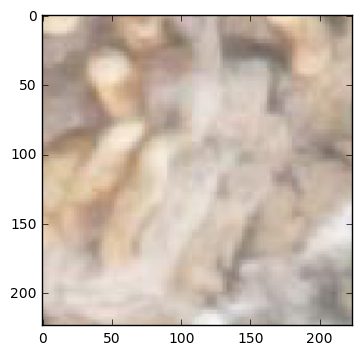

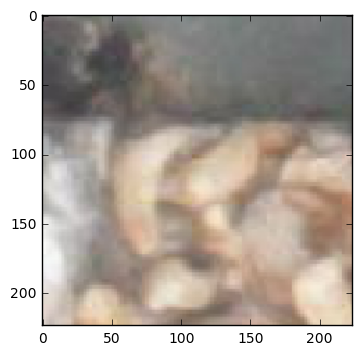

In [24]:
from matplotlib import pyplot as plt
%matplotlib inline
for index,row in df.iterrows():
    if index ==5:
        break
    row = row.tolist()
    image_file = os.path.join(TRAIN_DIR, row[0])
    bbox = row[2:6]
    cropped = load_img(image_file+'.jpg',bbox,target_size=(ROWS,COLS))
    plt.figure(figsize=(4,4))
    plt.imshow(cropped)